# A first bee/wasp discriminator using the FastAI library

To establish a baseline for future classification efforts, I am going to follow the outline in "Fastbook", the FastAI textbook, available at https://github.com/fastai/fastbook. My first objective is to train a simple and fast model which will classify an uploaded image as either a bee, a wasp, or neither. This is a first step towards an eventual genera classifier. (Note that this notebook must be run with Python 3.9, as this is the latest version supported by PyTorch and, hence, by FastAI.)

In [94]:
import os
import requests
from pathlib import Path
import json
from PIL import Image
from ipywidgets import widgets
from fastai.vision.all import *
from fastai.vision.widgets import *

We'll start by downloading basic sample data from a Bing search. This will be good enough for a simple bee/wasp discriminator, but probably not for classifying genera. We use the ```search_bing_images``` function from fastbook.utils.

In [46]:
key = os.environ.get('AZURE_SEARCH_KEY','524859eb34994576b0d53f906e8b30dd')

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'license':"public", 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     search_results = response.json()    
     return L(search_results['value'])


Let's download some images of bees, wasps, and bugs that fit into neither category. We'll need to be a litle careful about what ends up in this ```other``` folder.

In [60]:
classes = ['bee','wasp','other']
for cls in classes:
    path = Path(f'C:/users/mreek/documents/beedata/{cls}')
    path.mkdir(exist_ok=True)
    if cls != 'other':
        results = search_images_bing(key,cls, max_images = 400)
        download_images(path, urls=results.attrgot('contentUrl'))
    else:
        results = search_images_bing(key,'bug NOT bee NOT wasp', max_images = 400)
        download_images(path, urls=results.attrgot('contentUrl'))

In [61]:
for cls in classes:
    path = Path(f'./data/{cls}')
    fns = get_image_files(path)
    failed = verify_images(fns)
    failed.map(Path.unlink)

Now we can load the images into a DataBlock and take a look at our data. We use ```RandomResizedCrop``` to ensure a variety of views of each bug type.

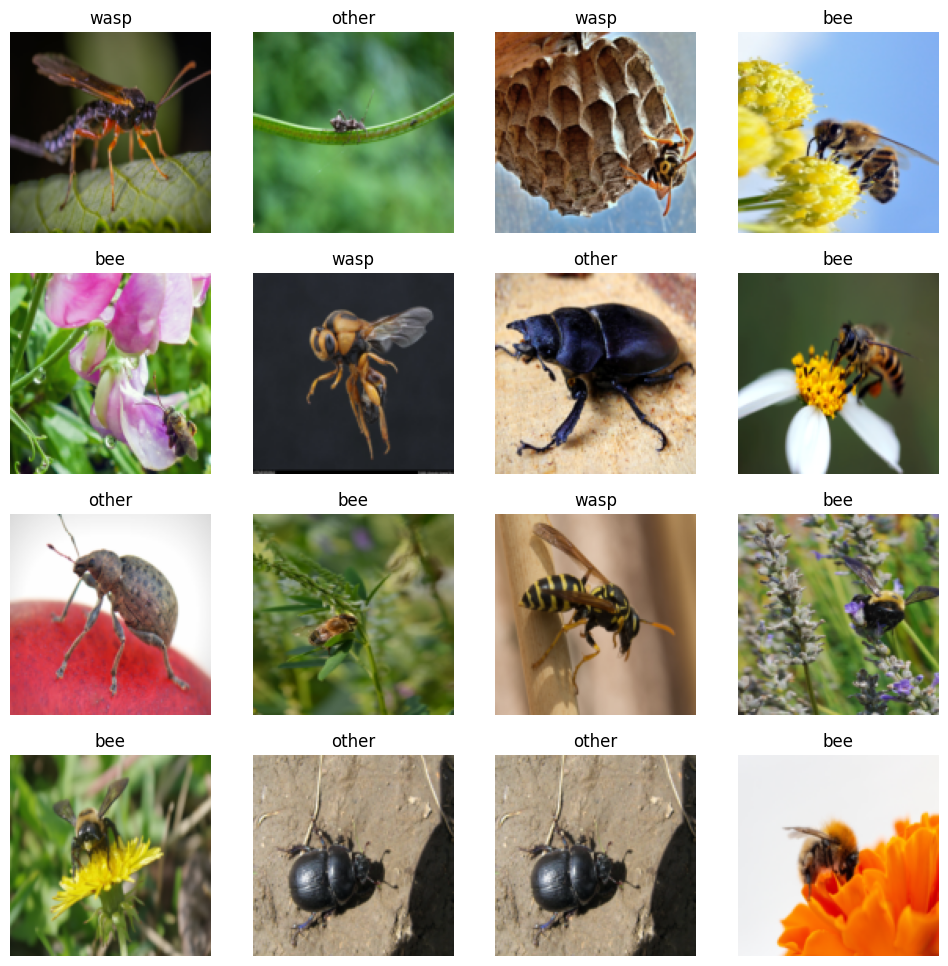

In [62]:

bugs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128,min_scale=0.3))

dls = bugs.dataloaders(Path('C:/users/mreek/documents/beedata/data'))
dls.valid.show_batch(max_n=16,nrows=4)
     

This sample looks pretty good. Since we only have ~400 of each image type (which appear to be mainly professional nature photos), we'll apply some standard augmentations to improve the robustness of our model.

Now we'll train a built-in Resnet for classification. We'll use a ```RandomResizedCrop``` with 224px and min scale 0.5.

In [64]:
bugs = bugs.new(item_tfms = RandomResizedCrop(224,min_scale=0.5), batch_tfms = aug_transforms())
dls = bugs.dataloaders(Path('C:/users/mreek/documents/beedata'))

learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.614209,0.279113,0.104938,01:59
1,0.467451,0.224577,0.061728,01:59
2,0.357484,0.157830,0.049383,01:59
3,0.276381,0.090950,0.043210,01:59
4,0.229459,0.095302,0.037037,01:58
5,0.188734,0.092430,0.043210,01:58


Let's see what kinds of errors we're making.

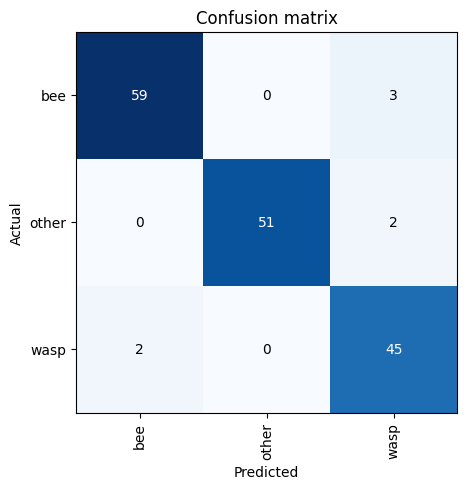

In [66]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

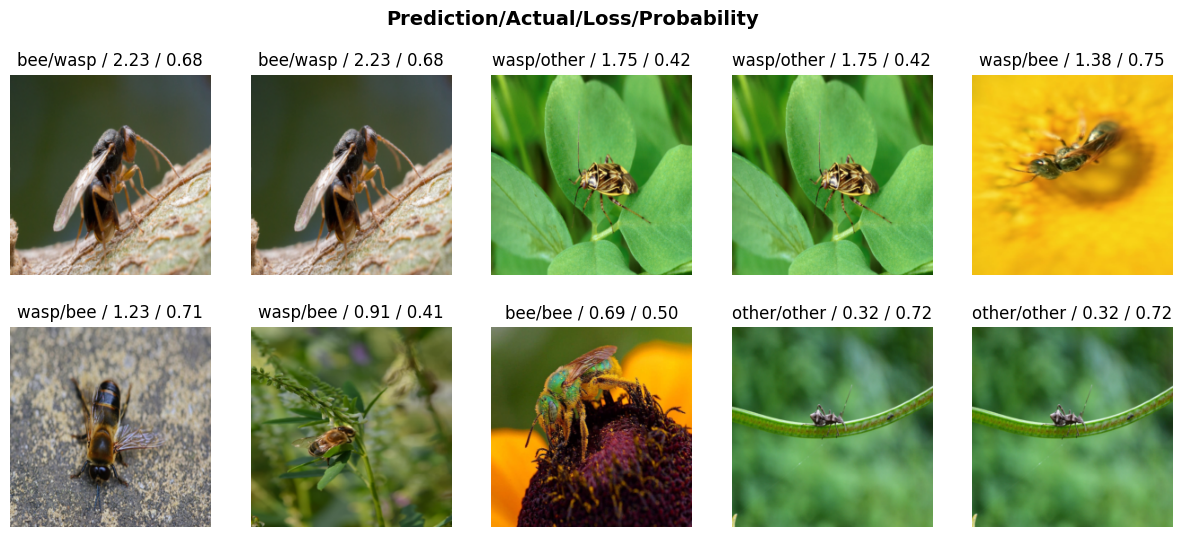

In [68]:
interp.plot_top_losses(10, nrows=2)

For the most part, these errors don't seem to be too worrying. That bug being misclassified as a wasp is a tarnished plant bug (*Lygus lineolaris*), and a particularly colorful example of one (I suspect the original image is oversaturated). The few wasp/bee confusions are a bit worse, but we expect some amount of confusion. These differences might be ironed out when we start looking at genera (since those models will be more sensitive to wasp-like bees and bee-like wasps.)

Next, let's try predicting on a few images I've taken. I expect the jewel bug to be tricky.

In [80]:
data = Path('C:/users/mreek/documents/tests').glob('*')
cls = []
for file in data:
    cls.append((file,learner.predict(file)))
print(cls)

[(Path('data/tests/bee.jpg'), ('wasp', TensorBase(2), TensorBase([0.0110, 0.0017, 0.9873]))), (Path('data/tests/jewelbug.jpg'), ('other', TensorBase(1), TensorBase([0.0017, 0.9035, 0.0948]))), (Path('data/tests/monarch.jpg'), ('other', TensorBase(1), TensorBase([1.2850e-03, 9.9780e-01, 9.1119e-04]))), (Path('data/tests/muddauber.jpg'), ('other', TensorBase(1), TensorBase([0.0722, 0.8932, 0.0346])))]


Hmm. Mixed results here. The model was not fooled by the jewel bug or monarch caterpillar, but thought a carpenter bee was a wasp and wasn't sure what to make of a mud dauber. These are important species in central PA (and most of the upper US), so maybe I should augment the training data with some specifically chosen images.  

In [81]:
#adding carpenter bees
path = Path('C:/users/mreek/documents/beedata/bee')
results = search_images_bing(key,'carpenter bee', max_images = 100)
download_images(path, urls=results.attrgot('contentUrl'))
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)
#adding mud daubers
path =  Path('C:/users/mreek/documents/beedata/wasp')
results = search_images_bing(key,'mud dauber', max_images = 100)
download_images(path, urls=results.attrgot('contentUrl'))
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

Let's also take a look at the top loss images and see if there's anything that shouldn't be there.

In [95]:
cleaner = ImageClassifierCleaner(learner)
cleaner


There is, so we'll remove it. (Lots of pictures of yellow garden spiders in the wasp folder, for some reason.)

In [96]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now to retrain the model with our new data.

In [97]:
bugs = bugs.new(item_tfms = RandomResizedCrop(224,min_scale=0.5), batch_tfms = aug_transforms())
dls = bugs.dataloaders(Path('C:/users/mreek/documents/beedata'))

learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.598593,0.371440,0.137143,05:06
1,0.501352,0.401490,0.177143,02:29
2,0.407622,0.253709,0.102857,05:05
3,0.327792,0.282805,0.080000,05:17
4,0.267899,0.277580,0.074286,04:49
5,0.236970,0.273874,0.085714,01:58


And let's try those test images again. I'll be happy as long as the model picks up the very clear image of a carpenter bee. 

In [99]:
data = Path('C:/users/mreek/documents/tests').glob('*')
cls = []
for file in data:
    cls.append((file,learner.predict(file)))
print(cls)

[(Path('C:/users/mreek/documents/tests/bee.jpg'), ('wasp', TensorBase(2), TensorBase([0.0080, 0.0024, 0.9896]))), (Path('C:/users/mreek/documents/tests/jewelbug.jpg'), ('other', TensorBase(1), TensorBase([0.0010, 0.6978, 0.3012]))), (Path('C:/users/mreek/documents/tests/monarch.jpg'), ('other', TensorBase(1), TensorBase([4.8183e-04, 9.4636e-01, 5.3155e-02]))), (Path('C:/users/mreek/documents/tests/muddauber.jpg'), ('bee', TensorBase(0), TensorBase([0.8276, 0.0664, 0.1060])))]
